Pt = Satellite Transmitter Power (in Decibel Watts, dBw) = 10 dBW
Gt = Satellite Antenna Gain (in Decibel Isotopic, dBi) = 9 dBi
Losses (in Decibels, db) = 19.43 db
ηR = Ground Station Antenna efficiency = 0.55
λ = c/f = Speed of Light/Carrier Frequency (in meters, m) =
0.136363636 m
kb = Boltzmann Constant (in Decibel Watts per degree Kelvin per
Hertz, dBW/K/Hz)= -228.6 dBW/K/Hz
TS = System Noise Temperature (in degrees Kelvin, K) = 22 K

TODO: dr = Ground Station Antenna Diameter (in meters, m)
TODO: R = Slant Range (in kilometers, km)

DSS24 = 34m
DSS34 = 34m
DSS54 = 34m
WPSA = 12m

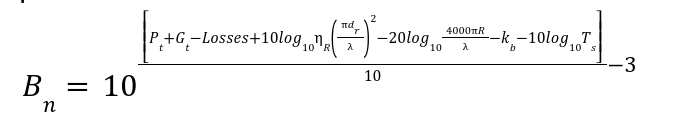

In [2]:
pt = 10
gt = 9
losses = 19.43
nr = 0.55
l = 0.136363636
kb = -228.6
ts = 22
dr = [34,34,34,12]

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

antennadf = pd.read_csv("./data/antenna_plot.csv", index_col=False)
satelitedf = pd.read_csv("./data/starting_data/hsdata.csv", index_col=False)
print(antennadf.shape, satelitedf.shape)

(51924, 5) (12981, 18)


In [3]:
antennadf.head()

,Antenna,Time (sec),X,Y,Z
0,DSS 24,0.000000,6132.732566,5437.728124,3689.829568
1,DSS 24,494.188833,5950.505743,5584.040250,3768.834568
2,DSS 24,554.188833,5928.055410,5601.314239,3778.567979
3,DSS 24,614.188833,5905.535950,5618.481001,3788.331360
4,DSS 24,674.188833,5882.947795,5635.540210,3798.124525


In [4]:
satelitedf.head()

,MISSION ELAPSED TIME (min),Rx(km)[J2000-EARTH],Ry(km)[J2000-EARTH],Rz(km)[J2000-EARTH],Vx(km/s)[J2000-EARTH],Vy(km/s)[J2000-EARTH],Vz(km/s)[J2000-EARTH],MASS (kg),WPSA,WPSA Range,DS54,DS54 Range,DS24,Range DS24,DS34,Range DS34,Unnamed: 16,Unnamed: 17
0,0.000000,3689.773564,4222.722170,3028.891599,-0.307917,0.268539,0.000720,4592.60000,1,1139.486313,0,NaN,0,NaN,0,NaN,NaN,NaN
1,8.236481,2319.817224,4865.712767,3698.167005,-7.474524,2.142613,2.894977,60129.73972,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
2,9.236481,1865.808701,4981.749611,3862.256016,-7.652172,1.724828,2.573246,60129.73972,0,NaN,1,3804.920572,0,NaN,0,NaN,NaN,NaN
3,10.236481,1402.384261,5072.667625,4006.812686,-7.788451,1.305814,2.244322,60129.73972,0,NaN,1,3804.920572,0,NaN,0,NaN,NaN,NaN
4,11.236481,932.010471,5138.480400,4131.480818,-7.883949,0.888450,1.910702,60129.73972,0,NaN,1,3804.920572,0,NaN,0,NaN,NaN,NaN


In [11]:
def has_line_of_sight(antenna, satellite, earth_radius=6378.137):
    """
    Determines if there's an unobstructed line of sight between an antenna and satellite.
    
    Args:
        antenna (tuple): Geocentric coordinates (x, y, z) of antenna in km
        satellite (tuple): Geocentric coordinates (x, y, z) of satellite in km
        earth_radius (float): Earth's radius in meters (default: 6378)
    
    Returns:
        int: 1 if line of sight exists, 0 if obstructed
    """
    # Unpack coordinates
    x1, y1, z1 = antenna
    x2, y2, z2 = satellite
    
    #Find differences
    dvector = [x2 - x1, y2 - y1, z2 - z1]
    for t in range(0,1000,1):
        # Calculate the position of the satellite at time t
        x = x1 + dvector[0] * (t/1000)
        y = y1 + dvector[1] * (t/1000)
        z = z1 + dvector[2] * (t/1000)
        
        # Calculate distance from the center of the Earth
        distance_from_center = np.sqrt(x**2 + y**2 + z**2)
        
        # Check if the distance is less than Earth's radius
        if distance_from_center < earth_radius:
            return 0
    return 1

lineofsighttest = {0:[], 1:[], 2:[], 3:[]}
for i in range(4):
    for j in range(satelitedf.shape[0]):
        lineofsighttest[i].append(has_line_of_sight([antennadf.iloc[(i*12981)+j]["X"], antennadf.iloc[(i*12981)+j]["Y"], antennadf.iloc[(i*12981)+j]["Z"]], [satelitedf.iloc[j]["Rx(km)[J2000-EARTH]"], satelitedf.iloc[j]["Ry(km)[J2000-EARTH]"], satelitedf.iloc[j]["Rz(km)[J2000-EARTH]"]]))
lineofsightdf = pd.DataFrame(lineofsighttest)
lineofsightdf.columns = ["LOS1", "LOS2", "LOS3", "LOS4"]
lineofsightdf["LOS1"] = lineofsightdf["LOS1"].astype(int)
lineofsightdf["LOS2"] = lineofsightdf["LOS2"].astype(int)
lineofsightdf["LOS3"] = lineofsightdf["LOS3"].astype(int)
lineofsightdf["LOS4"] = lineofsightdf["LOS4"].astype(int)
lineofsightdf.to_csv("./data/lineofsighttest.csv", index=False)

![image.png](attachment:image.png)

In [5]:
linkbudget = [[] for i in range(4)]
elevation_angles_tf = [[] for i in range(4)]
sr = []
for i in range(antennadf.shape[0]):
    slantrange = 0
    if (int(i/12981) == 0):
        if (satelitedf["DS24"].iloc[i%12981] == 1):
            slantrange = satelitedf["Range DS24"].iloc[i%12981]
        elevation_angles_tf[int(i/12981)].append(satelitedf["DS24"].iloc[i%12981])
    elif (int(i/12981) == 1 and satelitedf["DS34"].iloc[i%12981] == 1):
        if (satelitedf["DS34"].iloc[i%12981] == 1):
            slantrange = satelitedf["Range DS34"].iloc[i%12981]
        elevation_angles_tf[int(i/12981)].append(satelitedf["DS34"].iloc[i%12981])
    elif (int(i/12981) == 2 and satelitedf["DS54"].iloc[i%12981] == 1):
        if (satelitedf["DS54"].iloc[i%12981] == 1):
            slantrange = satelitedf["DS54 Range"].iloc[i%12981]
        elevation_angles_tf[int(i/12981)].append(satelitedf["DS54"].iloc[i%12981])
    else:
        if (satelitedf["WPSA"].iloc[i%12981] == 1):
            slantrange = satelitedf["WPSA Range"].iloc[i%12981]
        elevation_angles_tf[int(i/12981)].append(satelitedf["WPSA"].iloc[i%12981])
# print(antenna_available)tedf["WPSA"].iloc[i%12981])
    
    if (slantrange != 0):
        toppart = pt+gt-losses+10*np.log10(nr*((np.pi*dr[int(i/12981)]/l)**2))-20*np.log10(4000*np.pi*slantrange/l)-kb-10*np.log10(ts)
        exponent = (toppart/10)-3
        # if ((10**exponent) > 10000):
        #     linkbudget[int(i/12981)].append(10000)
        # else:
        linkbudget[int(i/12981)].append(10**exponent)
    else:
        linkbudget[int(i/12981)].append(0)
    sr.append(slantrange)
# list(aavailablestart[i].values().index(min(list(aavailablestart[i].values())))))


In [6]:
antennae_names = ["DSS24", "DSS34", "DSS54", "WPSA"]
antenna_available = [{} for i in range(12981)]
for i in range(12981):
    temp = []
    # minimum = np.float64(18446744073709551615.0)
    for j in range(4):
        if (linkbudget[j][i] > 0 and linkbudget[j][i] <= 10000):
            temp.append(linkbudget[j][i])
        elif (linkbudget[j][i] > 10000):
            temp.append(np.float64(10000))
        # print (linkbudget[j][i])
    # print(temp)
    if (len(temp) == 0):
        temp = [0]
    name = antennae_names[temp.index(max(temp))]
    antenna_available[i][name] = max(temp)
print(antenna_available)


[{'DSS24': np.float64(10000.0)}, {'DSS24': 0}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': np.float64(10000.0)}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS24': 0}, {'DSS

In [7]:

for i in range(4):
    link_budget_df = pd.DataFrame()
    link_budget_df["Time (min)"] = satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981]
    link_budget_df["Link Budget (kbps)"] = linkbudget[i]
    link_budget_df["Line Of Sight (1/0)"] = elevation_angles_tf[i]
    # print(antennadf.iloc[12981*i:12981*(i+1)]["X"])
    link_budget_df["Antenna X"] = antennadf["X"].to_list()[12981*i:12981*(i+1)]
    link_budget_df["Antenna Y"] = antennadf["Y"].to_list()[12981*i:12981*(i+1)]
    link_budget_df["Antenna Z"] = antennadf["Z"].to_list()[12981*i:12981*(i+1)]
    # link_budget_df["Satellite X"] = X[12981*i:12981*(i+1)]
    # link_budget_df["Satellite Y"] = Y[12981*i:12981*(i+1)]
    # link_budget_df["Satellite Z"] = Z[12981*i:12981*(i+1)]
    link_budget_df["Satellite X"] = satelitedf["Rx(km)[J2000-EARTH]"]
    link_budget_df["Satellite Y"] = satelitedf["Ry(km)[J2000-EARTH]"]
    link_budget_df["Satellite Z"] = satelitedf["Rz(km)[J2000-EARTH]"]
    print(link_budget_df.head())
    link_budget_df.to_csv("./data/link_budget_"+antennae_names[i]+".csv", index=False)

# add linkbudget columns to hsdata.csv
satelitedf["DS24_link_budget"] = linkbudget[0]
satelitedf["DS34_link_budget"] = linkbudget[1]
satelitedf["DS54_link_budget"] = linkbudget[2]
satelitedf["WPSA_link_budget"] = linkbudget[3]
satelitedf.to_csv("./data/hsdata_altered.csv", index=False)

# link_budget_df.head()

   Time (min)  Link Budget (kbps)  Line Of Sight (1/0)    Antenna X  \
0    0.000000                 0.0                    0  6132.732566   
1    8.236481                 0.0                    0  5950.505743   
2    9.236481                 0.0                    0  5928.055410   
3   10.236481                 0.0                    0  5905.535950   
4   11.236481                 0.0                    0  5882.947795   

     Antenna Y    Antenna Z  Satellite X  Satellite Y  Satellite Z  
0  5437.728124  3689.829568  3689.773564  4222.722170  3028.891599  
1  5584.040250  3768.834568  2319.817224  4865.712767  3698.167005  
2  5601.314239  3778.567979  1865.808701  4981.749611  3862.256016  
3  5618.481001  3788.331360  1402.384261  5072.667625  4006.812686  
4  5635.540210  3798.124525   932.010471  5138.480400  4131.480818  
   Time (min)  Link Budget (kbps)  Line Of Sight (1/0)    Antenna X  \
0    0.000000        9.127664e+07                    1  5505.389605   
1    8.236481    

In [8]:
antenna_availability = pd.DataFrame()
# COLUMNS: TIME, ANTENNA XYZ, AVAILABLE SATELLITE NAME, SATELLITE XYZ, Link Budget
antenna_availability["Time (min)"] = satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981]
link_budget_df["Antenna X"] = antennadf["X"].to_list()[:12981]
link_budget_df["Antenna Y"] = antennadf["Y"].to_list()[:12981]
link_budget_df["Antenna Z"] = antennadf["Z"].to_list()[:12981]
aakeys = []
for i in range(len(antenna_available)):
    aakeys.append(list(antenna_available[i].keys())[0])

aavalues = []
for i in range(len(antenna_available)):
    aavalues.append(list(antenna_available[i].values())[0])
antenna_availability["Available Satellite"] = aakeys
antenna_availability["Link Budget (kbps)"] = aavalues
antenna_availability["Satellite X"] = satelitedf["Rx(km)[J2000-EARTH]"]
antenna_availability["Satellite Y"] = satelitedf["Ry(km)[J2000-EARTH]"]
antenna_availability["Satellite Z"] = satelitedf["Rz(km)[J2000-EARTH]"]
print(antenna_availability.head())
antenna_availability.to_csv("./data/antenna_availability.csv", index=False)


   Time (min) Available Satellite  Link Budget (kbps)  Satellite X  \
0    0.000000               DSS24             10000.0  3689.773564   
1    8.236481               DSS24                 0.0  2319.817224   
2    9.236481               DSS24             10000.0  1865.808701   
3   10.236481               DSS24             10000.0  1402.384261   
4   11.236481               DSS24             10000.0   932.010471   

   Satellite Y  Satellite Z  
0  4222.722170  3028.891599  
1  4865.712767  3698.167005  
2  4981.749611  3862.256016  
3  5072.667625  4006.812686  
4  5138.480400  4131.480818  


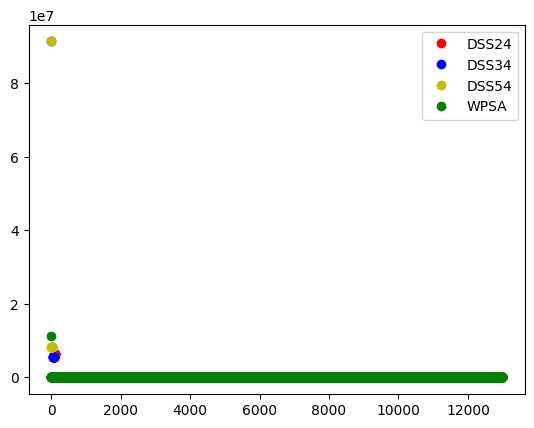

In [9]:
# plt.plot(satelitedf["MISSION ELAPSED TIME (min)"])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], linkbudget[0], 'ro', label = antennae_names[0])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], linkbudget[1], 'bo', label = antennae_names[1])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], linkbudget[2], 'yo', label = antennae_names[2])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], linkbudget[3], 'go', label = antennae_names[3])
plt.legend()
plt.show()

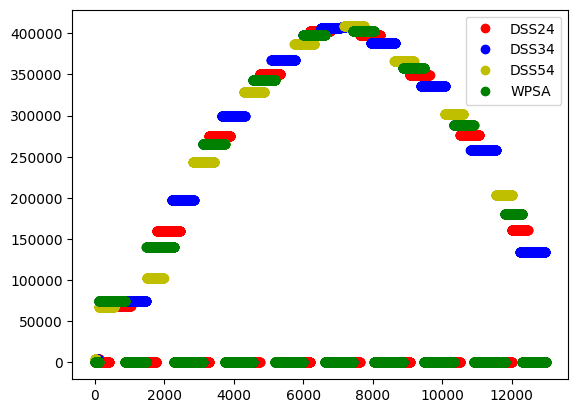

In [10]:
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], sr[:12981], 'ro', label = antennae_names[0])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], sr[12981:12981*2], 'bo', label = antennae_names[1])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], sr[12981*2:12981*3], 'yo', label = antennae_names[2])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], sr[12981*3:12981*4], 'go', label = antennae_names[3])
plt.legend()
plt.show()

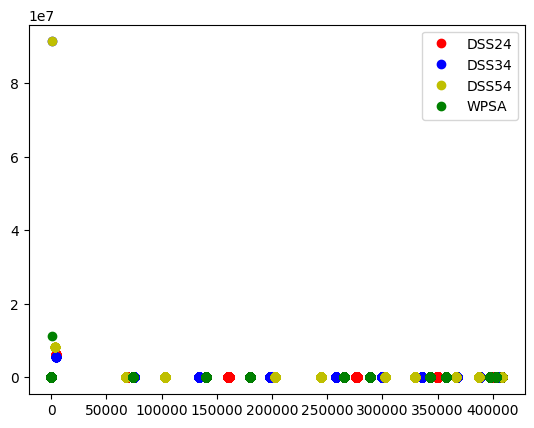

In [11]:
plt.plot(sr[:12981], linkbudget[0], 'ro', label = antennae_names[0])
plt.plot(sr[12981:12981*2], linkbudget[1], 'bo', label = antennae_names[1])
plt.plot(sr[12981*2:12981*3], linkbudget[2], 'yo', label = antennae_names[2])
plt.plot(sr[12981*3:12981*4], linkbudget[3], 'go', label = antennae_names[3])
plt.legend()
plt.show()

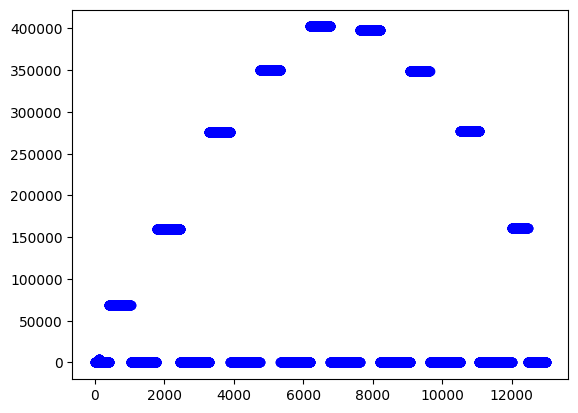

In [12]:
# plt.plot(satelitedf["MISSION ELAPSED TIME (min)"])
plt.plot(satelitedf["MISSION ELAPSED TIME (min)"].iloc[:12981], sr[:12981], 'bo')
plt.show()